# Rewriting Activation Maps  
**An Encoder Network that Enables a Pre-trained StyleGAN2 Model to Perform Image-to-image Translation**  
###### Coding Three: Exploring Machine Intelligence   

Author: Jasper Zheng (Shuoyang) / 21009460  

<img src='./docs/leaf.jpg' width='500px'></img>

This project proposed a novel training system appended to [StyleGAN2](https://github.com/NVlabs/stylegan2) architecture, enabling a pre-trained StyleGAN2 model to perform image-to-image translation, even if the input images are not in the original domain. The training system is based on an encoder network that downscales the generated images from a StyleGAN2 model and matches the distribution of the earlier activation maps in the same model (i.e. predict feature maps given a generated image). After training, the encoder network is migrated to the StyleGAN2 model.   

The proposed system was implemented on a couple of pre-trained models. And the results showed that it's able to create meaningful image-to-image translation different with [pix2pixHD](https://github.com/NVIDIA/pix2pixHD) and other state-of-the-art image translation models.  

In addition, a real-time interactive system was built to facilitate human control of the network.   




## Requirements:  

In [ ]:
!pip install tensorflow==2.3.0
!pip install tensorflow-addons==0.13.0
!pip install numpy==1.19.0

## Init  

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
!git clone https://github.com/jasper-zheng/rewriting-activation-maps.git 

In [7]:
%cd /content/rewriting-activation-maps/stylegan2_tf2
!nvcc test_nvcc.cu -o test_nvcc -run

/content/rewriting-activation-maps/stylegan2_tf2
CPU says hello.
GPU says hello.


In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from stylegan2.generator import load_and_restore
from stylegan2.utils import postprocess_images
from stylegan2.layers.cuda.upfirdn_2d_v2 import upsample_2d, compute_paddings

from PIL import Image
import os, os.path

# _Set Memory Growth:

from tensorflow import config, test
from tensorflow import __version__ as tf_version

physical_devices = config.list_physical_devices('GPU')
config.experimental.set_memory_growth(physical_devices[0], True)

print(physical_devices)
print(tf_version)
print(f'tf is using cuda: {test.is_built_with_cuda()}')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.3.0
tf is using cuda: True


## Download and Load the Trained Models

Here we download the pre-trained StyleGAN2 model, and the trained encoder model

#### Option 1: Painting Faces (MetFaces) Model

In [ ]:
!gdown --id 1-3AncVaH__aSwiGYPSyQC4n9ou1wW0y0
!gdown --id 1-9yA55QXj_6qBfNLwC-IBU7T9DXmJnSr

In [ ]:
!rm -r ./pretrained_metface/
!rm -r ./trained_encoder_metfaces/
!unzip ./pretrained_metface.zip
!unzip ./trained_encoder_metfaces.zip

In [ ]:
generator = load_and_restore('./pretrained_metface/cuda')

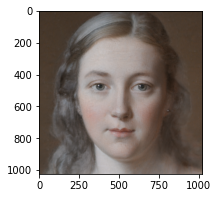

In [15]:
seed = 2291
rnd = np.random.RandomState(seed)

latents = rnd.randn(1, generator.z_dim).astype(np.float32)
labels = rnd.randn(1, generator.labels_dim).astype(np.float32)
image_out,intermediate_y = generator([latents, labels], 
                                    ret_w_broadcasted=False, 
                                    training=False, 
                                    truncation_psi=0.6,
                                    return_intermediate_y=True)
plt.figure(figsize=(3,3))
plt.imshow(postprocess_images(image_out)[0])

#### Option 2: Leaf Model

In [ ]:
!gdown --id 1-7WxnuhyRbQnIt-n9qQ3BYXJkvnaN_6f
!gdown --id 1-Bd2SNApEGeWBa3DyPfIvZAG8rWtrq8G

In [ ]:
!rm -r ./pretrained_metface/
!rm -r ./trained_encoder_metfaces/
!unzip ./pretrained_metface.zip
!unzip ./trained_encoder_metfaces.zip

## Disassemble the StyleGAN2 Model  

Then we open the synthesise network, manually setup the inference pipeline. Therefore we can extract the intermediate activation maps.  

In [19]:
k, pad0, pad1 = compute_paddings([1, 3, 3, 1], None, up=True, down=False, is_conv=False)

dlatents = generator.layers[0]([latents, labels])
w_broadcasted = generator.layers[1](dlatents)
w_broadcasted_t = generator.truncation_trick(w_broadcasted, 0.6)
print(f'latent vector: {dlatents.shape}, \nbroadcasted latent vector: {w_broadcasted_t.shape}')

latent vector: (1, 512), 
broadcasted latent vector: (1, 18, 512)


In [23]:
%%time

inputs = tf.concat([w_broadcasted_t,w_broadcasted],axis=0)

y4 = generator.layers[2].initial_block(inputs[:, 0])

y8 = generator.layers[2].blocks[0].conv_0([y4,inputs[:, 0]])
y8 = generator.layers[2].blocks[0].apply_noise_0(y8)
y8 = generator.layers[2].blocks[0].apply_bias_act_0(y8)
y8_1 = generator.layers[2].blocks[0].conv_1([y8,inputs[:, 0]])
y8_1 = generator.layers[2].blocks[0].apply_noise_1(y8_1)
y8_1 = generator.layers[2].blocks[0].apply_bias_act_1(y8_1)

y16 = generator.layers[2].blocks[1].conv_0([y8_1,inputs[:, 0]])
y16 = generator.layers[2].blocks[1].apply_noise_0(y16)
y16 = generator.layers[2].blocks[1].apply_bias_act_0(y16)
y16_1_cov = generator.layers[2].blocks[1].conv_1([y16,inputs[:, 0]])

CPU times: user 32 ms, sys: 670 µs, total: 32.6 ms
Wall time: 31.6 ms


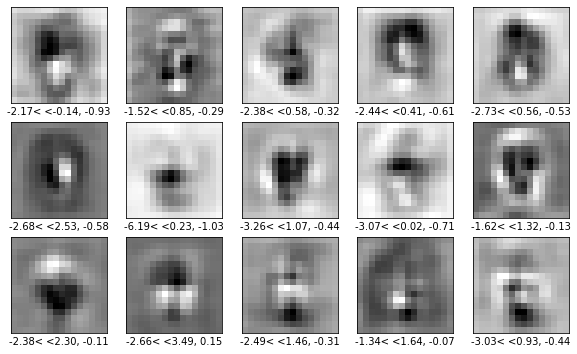

In [24]:
# _Plot 15 images by matplotlib.pyplot

plt.figure(figsize=(10,6))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(y16_1_cov[0][i], cmap='gray')
    plt.xlabel(f'{np.min(y16_1_cov[0][i]):.2f}< <{np.max(y16_1_cov[0][i]):.2f}, {np.mean(y16_1_cov[0][i]):.2f}')
plt.show()

## Build the Appended Encoder  

Now we build the appended encoder shown in the graph below.  

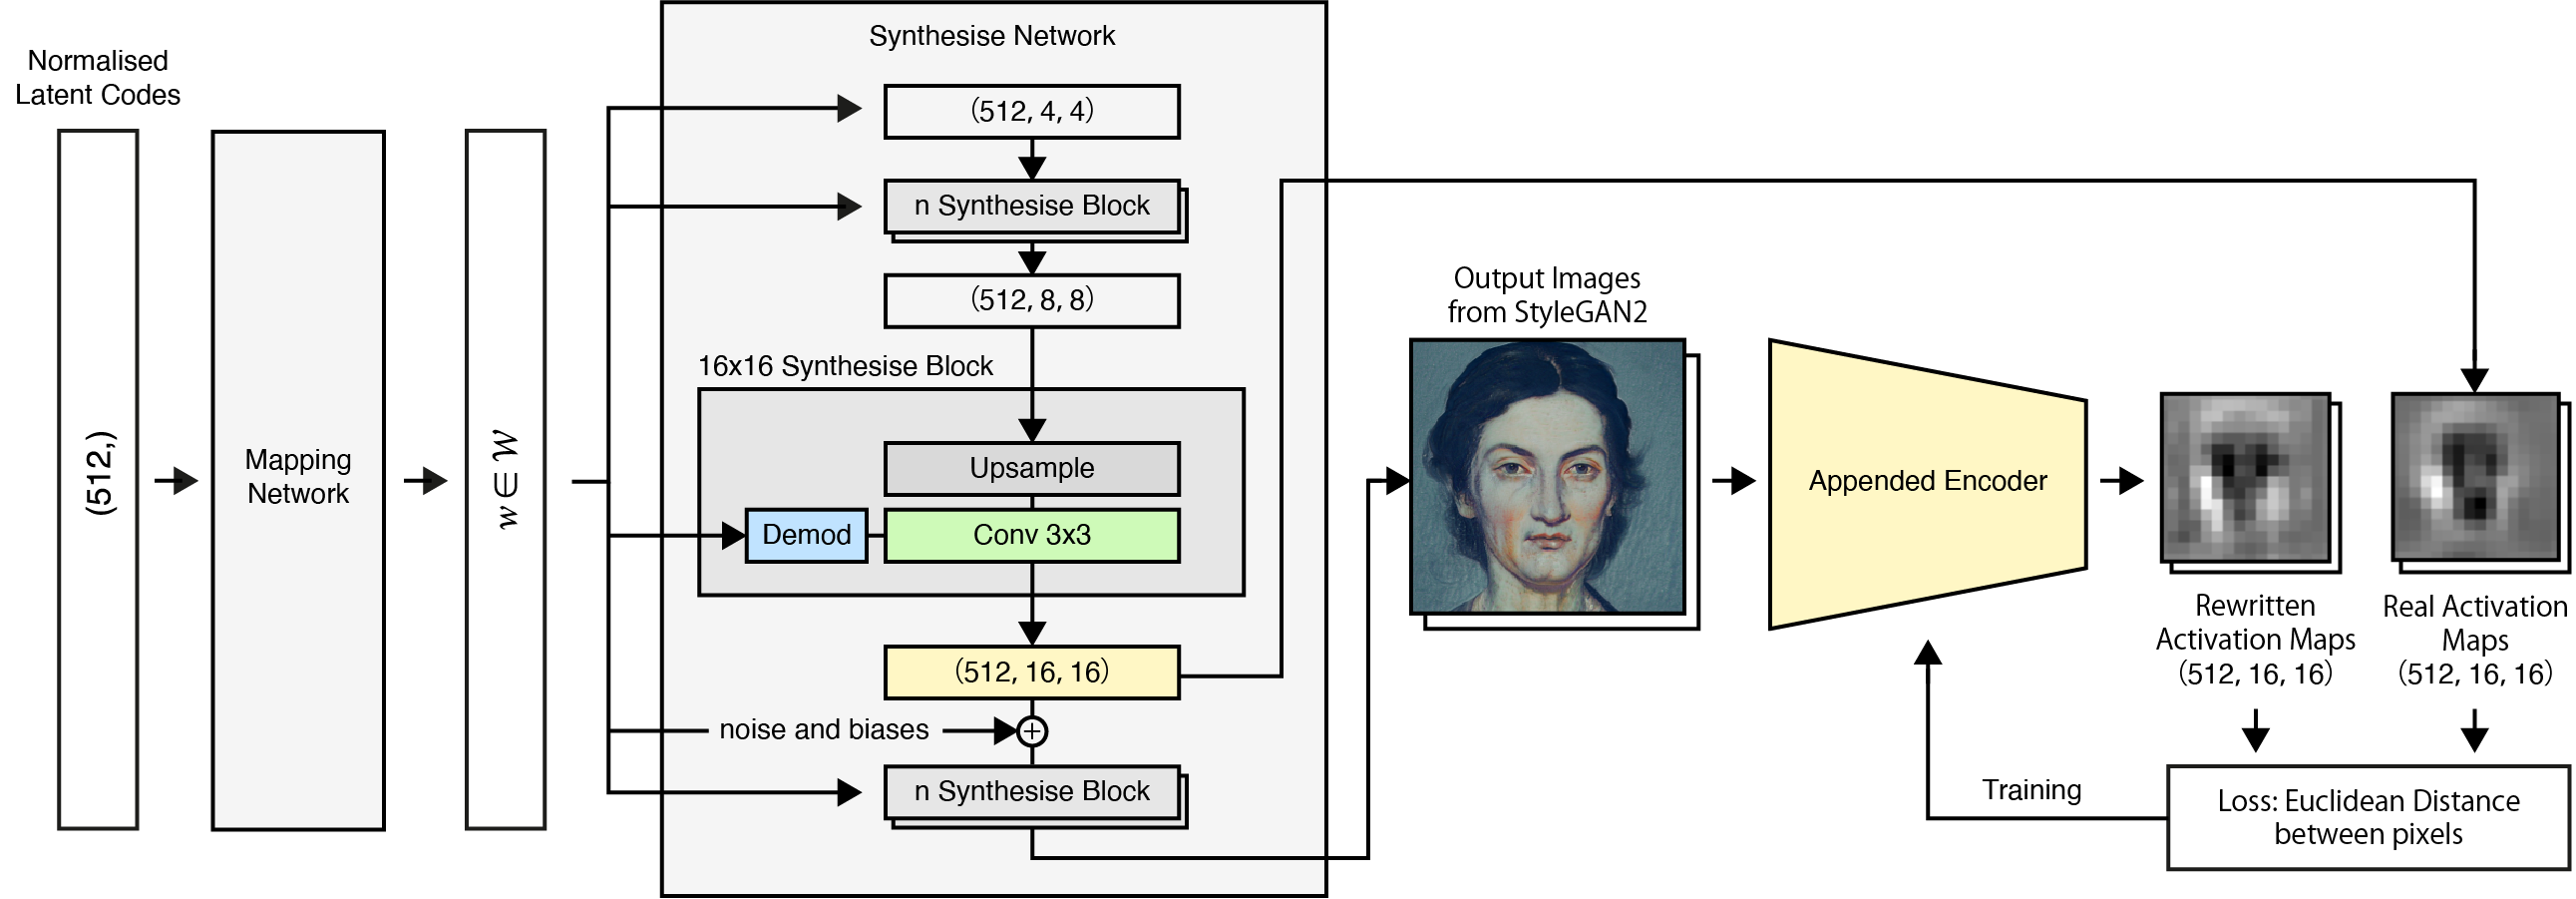

In [28]:
Image.open('../docs/graph_encoer_network.png')

<img src='./docs/graph_encoer_network.png'>

In [25]:
class MeanFilter(tf.keras.layers.Layer):
  def __init__(self):
    super(MeanFilter, self).__init__()

  def build(self,input_shape):
      self.compute_output_shape(input_shape)
      
  def compute_output_shape(self, inputs):
    self._spatial_output_shape(inputs)
    return inputs

  def _spatial_output_shape(self, spatial_input_shape):
    return spatial_input_shape

  def call(self, inputs):
    return tfa.image.mean_filter2d(inputs)

In [26]:
inputs_re = tf.keras.Input((256, 256, 3))

x = tf.keras.layers.Conv2D(64, (3,3), strides=(2,2), padding='same')(inputs_re)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) # 128,128,64

x = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) # 64,64,128

x = tf.keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = MeanFilter()(x)

x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) # 32,32,512

x = tf.keras.layers.Conv2D(512, (3,3), strides=(2,2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) # 16,16,512

x = tf.keras.layers.Conv2D(512, (3,3), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) # 16,16,512

x = tf.keras.layers.Conv2D(512, (1,1), padding='same')(x)

model_re = tf.keras.Model(inputs=inputs_re, outputs=x)